# Analysis on U.S. Patents and Pending Patent Applications

# 1. Introduction

For the time period 2000-2019, this analysis explores the following:

1. Technology centers - examination groups applications are assigned to based type of invention
2. United States Patent Classification (USPC) class numbers - applications are assigned a USPC class number based on the type of invention
3. Inventors - where are the inventors from?
4. Entity status - undiscounted, small, or micro
5. Assignees - who has the property right to the patent?

This analysis provides an overview of the types of inventions that have been patented and the owners of these patents. Additionally, analysis of the pending applications provides insight into the patents that are coming down the pipeline. The assignment dataset also provides a general idea of which countries and companies have strong U.S. patent portfolios.

# 1.1 Data

The Patent Examination Research Dataset (Public PAIR) and Patent Assignment Dataset used in this analysis were obtained from the United States Patent and Trademark Office (USPTO). The public PAIR dataset contains information on publicly viewable patent applications through April 2020. The patent assignment dataset contains information on assignments that have been recorded at the USPTO since 1970. 

Link to source: https://www.uspto.gov/ip-policy/economic-research/research-datasets

# 2. Data cleaning and preprocessing

In [1]:
#formatting notebook - wider cells and output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [2]:
#import packages and set options
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import plotly
import chart_studio.plotly as py
import plotly.graph_objects as go 
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#replace the default cycle colors with more selection of colors for plots using matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['blue', 'orange', 'green', 'red', 'purple',
'brown', 'pink', 'gray', 'olive','cyan', 'black', 'darkmagenta', 'dodgerblue', 'yellow',
'lightcoral','peru','lime', 'wheat', 'violet', 'teal', 'lightgray', 'sandybrown', 'magenta'])

In [3]:
#importing application_data.csv

#used the technical documentation from the USPTO specific to this dataset
#to determine which columns will be used
cols = ['application_number', 'filing_date', 'application_invention_type', 'examiner_art_unit',
       'appl_status_desc','uspc_class','uspc_subclass', 'patent_number', 'patent_issue_date',
       'invention_title', 'small_entity_indicator']

#large dataset, specify data types to help with import
types = {'application_number': str, 'filing_date': str, 'application_invention_type': str, 
         'examiner_art_unit': str, 'appl_status_desc': str, 'uspc_class': str, 'patent_number': str,
         'patent_issue_date': str,'invention_title': str, 'small_entity_indicator': str}

patents_all = pd.read_csv('application_data.csv', usecols=cols, dtype=types)

In [4]:
#importing all_inventors.csv

#used the technical documentation from the USPTO specific to this dataset
#to determine which columns will be used
cols_inventors = ['application_number', 'inventor_name_last', 'inventor_city_name',
                 'inventor_region_code', 'inventor_country_code']

#large dataset, specify data types to help with import
types_inventors = {'application_number': str, 'inventor_name_last': str, 'inventor_city_name': str,
                  'inventor_region_code': str, 'inventor_country_code': str}

inventors = pd.read_csv('all_inventors.csv', usecols=cols_inventors, dtype=types_inventors)

In [5]:
#importing assignee.csv

#large dataset, specify data types to help with import
types_assignee = {'rf_id': str, 'ee_nae':str, 'ee_address_1':str, 'ee_address_2':str, 'ee_city':str, 'ee_state':str,
                 'ee_postcode':str, 'ee_country': str}

assignee = pd.read_csv('assignee.csv', dtype=types_assignee)

In [6]:
#processing patents_all dataframe

#look at application_invention_type values
#patents_all['application_invention_type'].unique()

#keep rows with 'Utility', 'Design', and 'Plant' as application_invention_type values only;
#these are types of applications in U.S. that are examined by a patent examiner and may be issued as a patent
patents_examined = patents_all.loc[patents_all['application_invention_type'].isin(['Utility','Design','Plant'])]

#drop rows with na values in application_number and filing_date columns (at minimum, wanted each index to have values for these columns);
#patent_number and patent_issue_date can have na values; these rows correspond to pending patent applications
na_columns = ['application_number', 'filing_date']

#drop rows
patents_examined = patents_examined.dropna(subset=na_columns)

#remove last three rows from dataframe, these are test rows, not actual applications
patents_examined_apps = patents_examined.iloc[:-3]

#convert filing_date column from string to datetime format
patents_examined_apps['filing_date'] = pd.to_datetime(patents_examined_apps['filing_date'], format='%Y-%m-%d')

#create year_filing and month_filing columns from filing_date column
patents_examined_apps['year_filing'] = pd.DatetimeIndex(patents_examined_apps['filing_date']).year
patents_examined_apps['month_filing'] = pd.DatetimeIndex(patents_examined_apps['filing_date']).month

#create year-month_filing column
patents_examined_apps['year_month_filing'] = pd.to_datetime(patents_examined_apps['filing_date']).dt.to_period('M')

#drop filing date column
del patents_examined_apps['filing_date']

#remove rows with year_filing values of 2020, 2020 data is incomplete
#identify row names where year_filing == 2020
rows_2020_apps = patents_examined_apps[patents_examined_apps['year_filing'] == 2020].index
 
#drop rows_2020_apps
patents_examined_apps.drop(rows_2020_apps, inplace=True)

#processing_examiner_art_unit
#first two digits and adding two zeroes will give the technology center, for plotting later in analysis
patents_examined_apps['technology_center'] = patents_examined_apps['examiner_art_unit'].str[:2]
patents_examined_apps['technology_center'] = patents_examined_apps['technology_center'] + '00'

#subset patents_examined_apps (ALL applications) to create two separate dataframes
#(1) patented_applications and (2) pending_abandoned_applications

#(1) patented_applications
#remove rows with na values in 'patent numbers' column
patented_applications = patents_examined_apps.dropna(subset=['patent_number'])

#(2) pending_abandoned_applications (not issued as patents)
#keep rows with na values in patent_number; don't want rows with patent numbers
pending_abandoned_applications = patents_examined_apps[patents_examined_apps['patent_number'].isna()]

In [7]:
#further processing of patented_applications, pending_abandoned_applications, and inventors dataframes

#processing patented_applications dataframe
#convert patent_issue_date column from string to datetime format
patented_applications['patent_issue_date'] = pd.to_datetime(patented_applications['patent_issue_date'], 
                                                            format='%Y-%m-%d')
#create year_patent and month_patent columns from patent_issue_date column
patented_applications['year_patent'] = pd.DatetimeIndex(patented_applications['patent_issue_date']).year
patented_applications['month_patent'] = pd.DatetimeIndex(patented_applications['patent_issue_date']).month

#create year-month_patent column
patented_applications['year_month_patent'] = pd.to_datetime(patented_applications['patent_issue_date']).dt.to_period('M')

#drop patent_issue_date column
del patented_applications['patent_issue_date']

#remove rows with year_patent values of 2020, 2020 data is incomplete
#identify row names where 'year_patent' == 2020
rows_2020_pats = patented_applications[patented_applications['year_patent'] == 2020].index
 
#drop rows_2020_pats
patented_applications.drop(rows_2020_pats, inplace=True)

#convert year_patent column to string
patented_applications['year_patent'] = patented_applications['year_patent'].astype(str)

#processing pending_abandoned_applications
#application status descriptions relating to abandoned applications -- used pending_abandoned_applications['appl_status_desc'].unique()
#remove any status with 'Patent' values; some application data indicated 'Patented Case', even with no patent number or patent issue date; 
#don't want to use for this analysis
drop_list = ['Abandoned -- File-Wrapper-Continuation Parent Application','Abandoned -- Failure to Respond to an Office Action',
            'Expressly Abandoned -- During Examination',"Abandoned -- After Examiner's Answer or Board of Appeals Decision",
            'Abandoned -- Failure to Pay Issue Fee','Expressly Abandoned -- During Publication Process',
            'Abandoned -- Incomplete Application (Pre-examination)','Abandonment for Failure to Correct Drawings/Oath/NonPub Request',
            'Abandoned -- Incomplete (Filing Date Under Rule 53 (b) - PreExam)', 'Patented Case',
            'Patented File - (Old Case Added for File Tracking Purposes)']

#identify row names with the above abandon_list values in appl_status_desc
rows_abandon = pending_abandoned_applications[pending_abandoned_applications['appl_status_desc'].isin(drop_list)].index

#drop rows_abandon to create the pending_applications dataframe
pending_applications = pending_abandoned_applications.drop(rows_abandon)

#convert year_filing to string
pending_applications['year_filing'] = pending_applications['year_filing'].astype(str)

# 3. Analysis

## 3.1 Overview

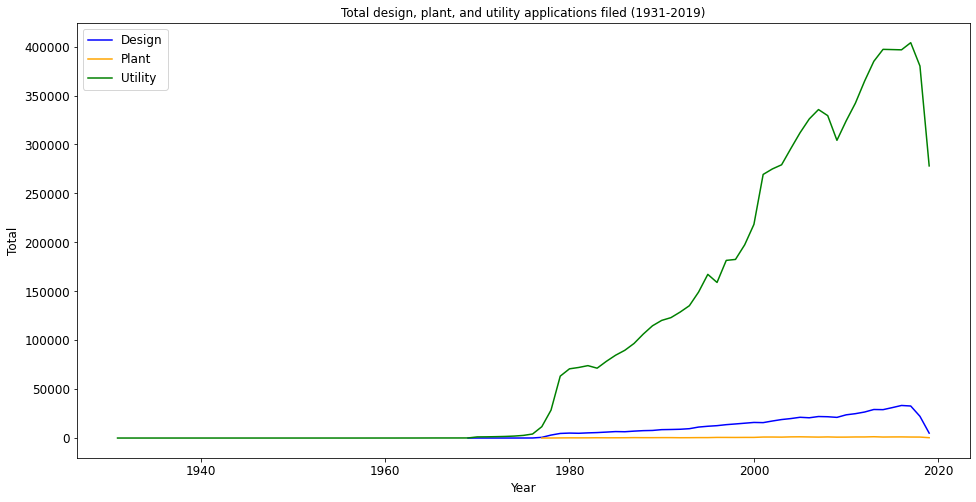

In [8]:
#plotting number of applications filed over time - 1931-2019
#use the patents_examined_apps dataframe, this would include patented, pending, and abandoned applications

#groupby year_filing
applications_filed = patents_examined_apps.groupby('year_filing')

#plot
#value_counts will give number of applications in each category
applications_filed['application_invention_type'].value_counts().unstack().plot(figsize=(16,8))
plt.title('Total design, plant, and utility applications filed (1931-2019)', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(fontsize = 12)
plt.tick_params(labelsize = 12)
plt.show()

We see a general increase in the number of applications filed over time, except for two noticeable drops starting in 2008 during the recession and another one starting in 2018. The steep drop from 2018 to 2019 is probably because some of the pending applications that were filed last year (2019) are still private so we won't to have access to that information until the applications are published.

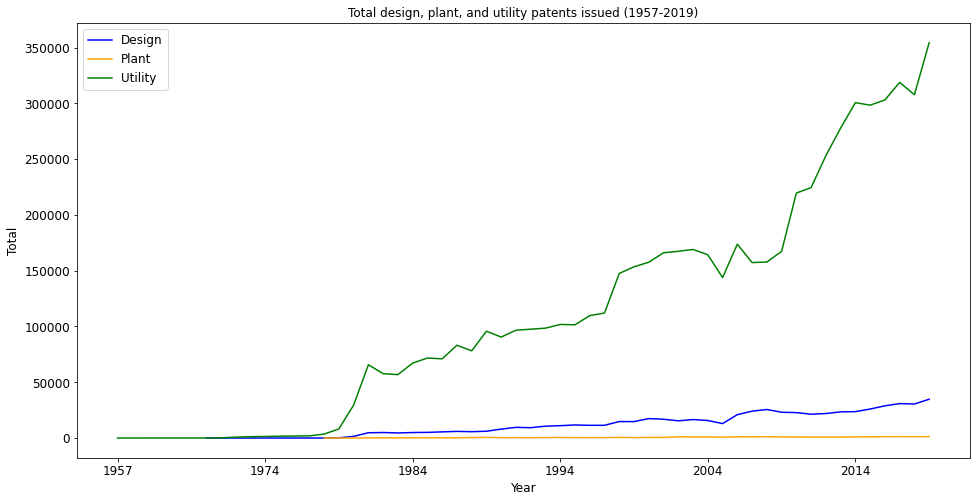

In [9]:
#plotting number of applications issued as patents over time (1957-2019)
#use patent_applications dataframe

#groupby year_patent
patents_issued = patented_applications.groupby('year_patent')

#plot
#value_counts will give number of patents issued for each category
patents_issued['application_invention_type'].value_counts().unstack().plot(figsize=(16,8))
plt.title('Total design, plant, and utility patents issued (1957-2019)', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(fontsize = 12)
plt.tick_params(labelsize = 12)

plt.show()

Note increase in the number of applications issued as patents by the USPTO from 2018 to 2019.

## 3.2 U.S. pending patent applications filed 2000-2019

In [10]:
#pending patent applications filed 2000-2019

#further processing of pending_applications
#subset to create a dataframe for pending applications filed in and after 2000
all_apps = pending_applications[pending_applications['year_filing'] >= '2000']

## 3.2.1 Technology Center (TC) Groups

In [11]:
#further processing of all_apps dataframe

#checking for unique 'technology center' values
#all_apps['technology_center'].unique()

#remove rows with values not considered one of the main 8 technology center group numbers
pending_all_droplist = ['2700','OP00', '3900','IP00', '4100', 'PT00', 'OE00','PI00', 
                   'DI00', '2900', 'PC00', 'IW00']

#remove rows with na values
pending_all_na = all_apps.dropna(subset=['technology_center'])

#identify row names with the above pending_all_droplist values in technology center
rows_all_pending = pending_all_na[pending_all_na['technology_center'].isin(pending_all_droplist)].index

#drop rows_all_pending to create the pending_apps_TC dataframe
pending_apps_TC = pending_all_na.drop(rows_all_pending)

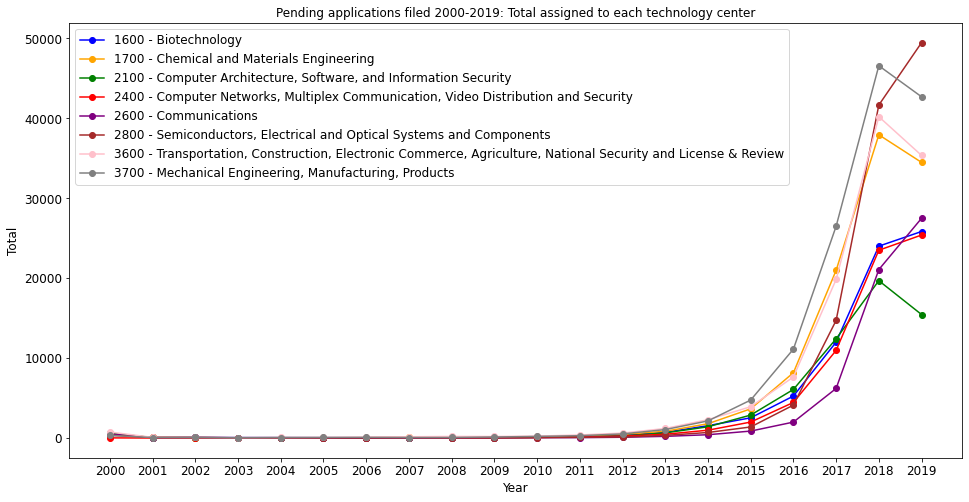

In [12]:
#plotting number of pending applications in each technology center (2010-2019)
#art unit - 8 technology centers for examining utility applications

#groupby year_filing
art_unit_pending = pending_apps_TC.groupby('year_filing')

#xtick labels
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
         '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

#plot
#value_counts will give number of pending applications assigned to each technology center
art_unit_pending['technology_center'].value_counts().unstack().plot(figsize=(16,8), marker ='o')
plt.title('Pending applications filed 2000-2019: Total assigned to each technology center', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.tick_params(labelsize = 12)
#20 xticks, 1 for each year
plt.xticks(np.arange(20), labels=years)
#modifying legend
#new labels
new_labels = ['1600 - Biotechnology',
              '1700 - Chemical and Materials Engineering',
              '2100 - Computer Architecture, Software, and Information Security',
              '2400 - Computer Networks, Multiplex Communication, Video Distribution and Security',
              '2600 - Communications', 
              '2800 - Semiconductors, Electrical and Optical Systems and Components', 
              '3600 - Transportation, Construction, Electronic Commerce, Agriculture, National Security and License & Review',
              '3700 - Mechanical Engineering, Manufacturing, Products']
plt.legend(labels = new_labels, fontsize=12)
plt.show()

Most of the pending applications filed between 2000-2019 were assigned to technology center (TC) group number 2800, followed by 3700, 3600, and 1700. 2800 - Semiconductors, Electrical and Optical Systems and Components; 3700 - Mechanical Engineering, Manufacturing, Products; 3600 - Transportation, Construction, Electronic Commerce, Agriculture, National Security and License & Review; 1700 - Chemical and Materials Engineering.

Note flat curves from 2000-2012. This means that most of the applications (at least the applications that we have data for) that were filed from 2000-2012 have been 'processed' - issued as a patent, abandoned, or under a different type of examination, for example, reexamination. 

Since most of data for pending patent applications is from 2013-2019, the next three sections will only use data from 2013-2019.

## 3.2.2  United States Patent Classification (USPC) class numbers (2013-2019)

In [13]:
#subsetting all_apps to create a dataframe with only pending applications filed 2013-2019
all_apps_2013_2019 = all_apps[all_apps['year_filing'] >= '2013']

#remove rows with na values in uspc_class column
all_apps_class_na = all_apps_2013_2019.dropna(subset=['uspc_class'])

#group by year
class_all_apps = all_apps_class_na.groupby('year_filing')

#use value_counts to determine how many pending applications are assigned to each uspto classification code
uspc_class_count = class_all_apps['uspc_class'].value_counts()

#groupby year and get top 10 classification codes
uspc_class_top = uspc_class_count.groupby(level=0).head(10).unstack()

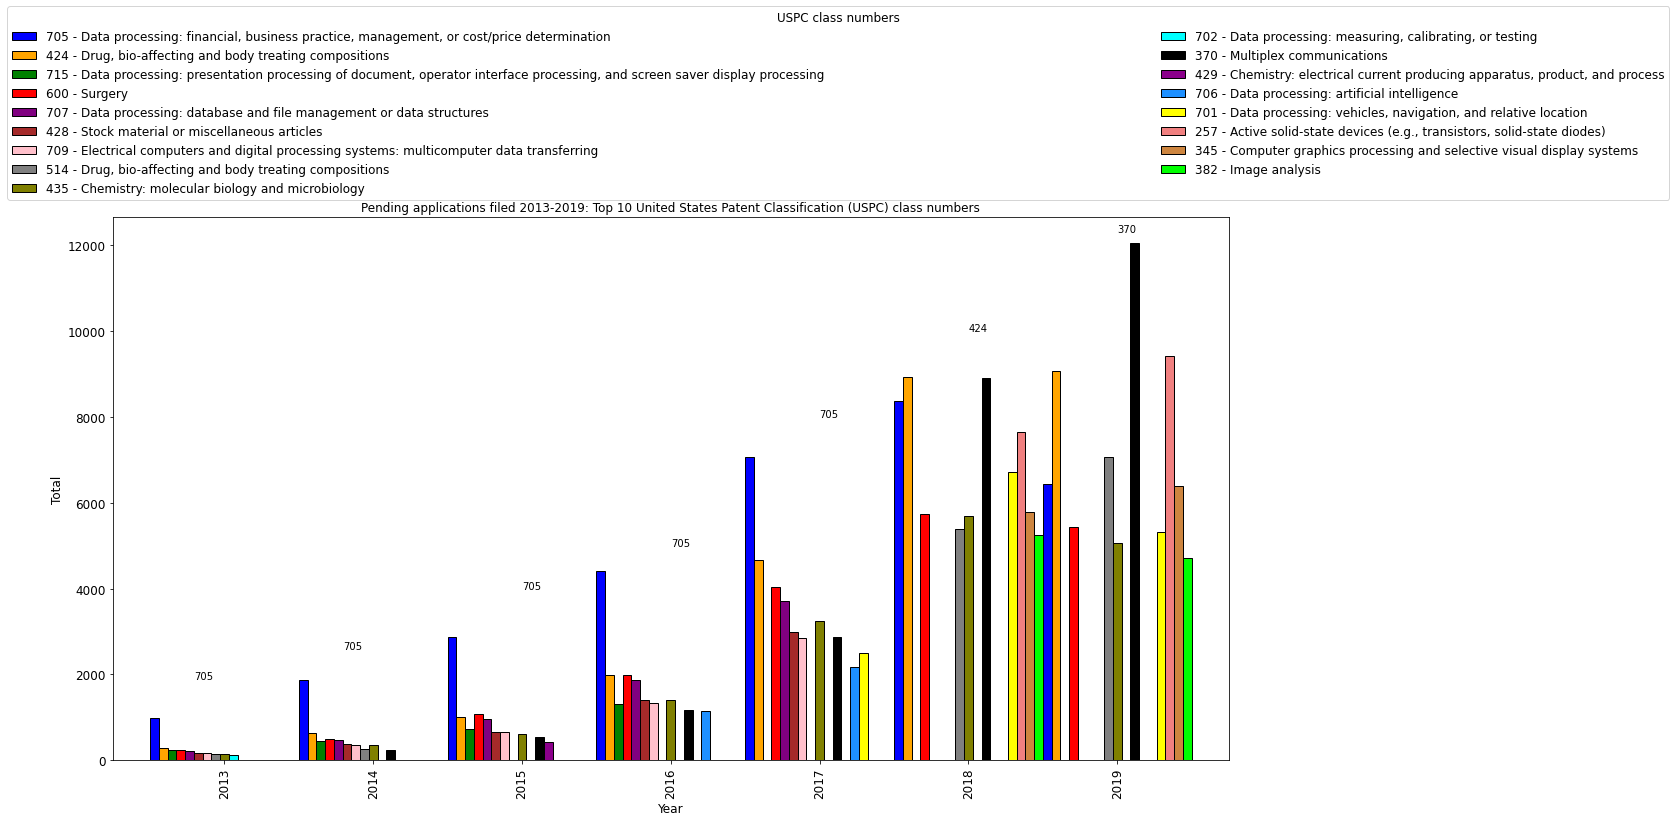

In [64]:
#plot
uspc_class_top.plot.bar(figsize=(20,10), width=1,edgecolor='black')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pending applications filed 2013-2019: Top 10 United States Patent Classification (USPC) class numbers', fontsize=12)

#adding top USPC class number above each grouping
plt.text(-.2, 1900, '705')
plt.text(.8, 2600, '705')
plt.text(2, 4000, '705')
plt.text(3, 5000, '705')
plt.text(4, 8000, '705')
plt.text(5, 10000, '424')
plt.text(6, 12300, '370')

#renaming labels to include number and description
class_labels = ['705 - Data processing: financial, business practice, management, or cost/price determination',
              '424 - Drug, bio-affecting and body treating compositions',
              '715 - Data processing: presentation processing of document, operator interface processing, and screen saver display processing',
              '600 - Surgery',
              '707 - Data processing: database and file management or data structures',
              '428 - Stock material or miscellaneous articles',
              '709 - Electrical computers and digital processing systems: multicomputer data transferring',
              '514 - Drug, bio-affecting and body treating compositions',
              '435 - Chemistry: molecular biology and microbiology',
              '702 - Data processing: measuring, calibrating, or testing',
              '370 - Multiplex communications',
              '429 - Chemistry: electrical current producing apparatus, product, and process',
              '706 - Data processing: artificial intelligence',
              '701 - Data processing: vehicles, navigation, and relative location',
              '257 - Active solid-state devices (e.g., transistors, solid-state diodes)',
              '345 - Computer graphics processing and selective visual display systems',
              '382 - Image analysis']

plt.legend(labels = class_labels, title='USPC class numbers', mode='expand', ncol=2, bbox_to_anchor=(-.1,1.02,1.5,0.2), loc="lower left",
           fontsize=12, title_fontsize=12)
plt.show()

From 2013-2017, 705 was the top USPC class number assigned to pending applications filed in that time period. 705 is for inventions related to data processing: financial, business practice, management, or cost/price determination. For 2018, top class number was 424. 424 is for inventions related to drug, bio-affecting and body treating compositions. For 2019, top class number was 370. 370 is for inventions related to multiplex communications.

# 3.2.3 Inventors (2013-2019)

In [15]:
#merging inventors dataframe and all_apps_2013_2019; analysis on inventors of pending applications
inventors_2013_2019 = pd.merge(all_apps_2013_2019, inventors, on='application_number')

#check if there are any na values
#inventors_2013_2019['inventor_country_code'].isnull().values.any()

#drop rows with na values in inventor_country_code column
inventors_country_pending = inventors_2013_2019.dropna(subset=['inventor_country_code'])

#removed na values, can use .size() to count number of inventors from each country
inventors_country_pending_count = inventors_country_pending.groupby(['year_filing','inventor_country_code']).size().reset_index(name='Total')

#rename column year_filing and inventor_country_code for plot labels
inventors_country_pending_count.rename(columns={"year_filing": "Year", 'inventor_country_code':'Country'}, inplace=True)
#view y range for plotting
#inventors_country_pending_count['count'].sort_values()

In [16]:
#plot - from plotly
fig = px.bar(inventors_country_pending_count, x="Country", y="Total", 
             title='Inventor count for each country for pending patent applications filed 2013-2019', 
             animation_frame="Year", range_y=[0,400000])
fig.show()

Top inventor countries: U.S., Japan, Korea, China, and Germany.

# 3.2.3.1 U.S. Inventors

In [17]:
#subset - U.S. inventors only, pending cases (2013-2019)
US_inventors = inventors_2013_2019[inventors_2013_2019['inventor_country_code'] == 'US']

#remove rows with na values in inventor_region_code (state)
US_inventors_final = US_inventors.dropna(subset=['inventor_region_code'])

#removed na values, can use .size() to determine inventor count for each state
US_inventors_count = US_inventors_final.groupby(['year_filing','inventor_region_code']).size().reset_index(name='count')
#view y range for plotting - 95,000
#US_inventors_count['count'].sort_values()

In [46]:
#from plotly, class lecture
def mapper_pending(year): #enter year as string
    plot_df = US_inventors_count.loc[US_inventors_count['year_filing'] == year] #subsetting dataframe by a given year
    
    fig =go.Figure(data=go.Choropleth(
        locations = plot_df['inventor_region_code'],
        z = plot_df['count'],
        text = plot_df['inventor_region_code'],
        locationmode='USA-states',
        autocolorscale=True,
        marker_line_color='rgb(255,255,255)',
        marker_line_width=2,
        colorbar_tickprefix = '',
        colorbar_title = 'Totals for ' + year
    ))
    
    fig.update_layout(
        title_text = 'Inventor count for each state for pending patent applications filed in ' + year + '<br>Hover for Value',
        geo = dict(
            showframe=False,
            showcoastlines=True,
            showlakes=True,
            lakecolor='rgb(95,145,237)',
            projection_type='albers usa') #try equirectangular
       
    )
    fig.show()

In [60]:
#user can enter years 2013-2019
mapper_pending('2019')

Top inventor states: California, Texas, New York, Washington, and Massachusetts.

# 3.2.4 Entity Status (2013-2019)

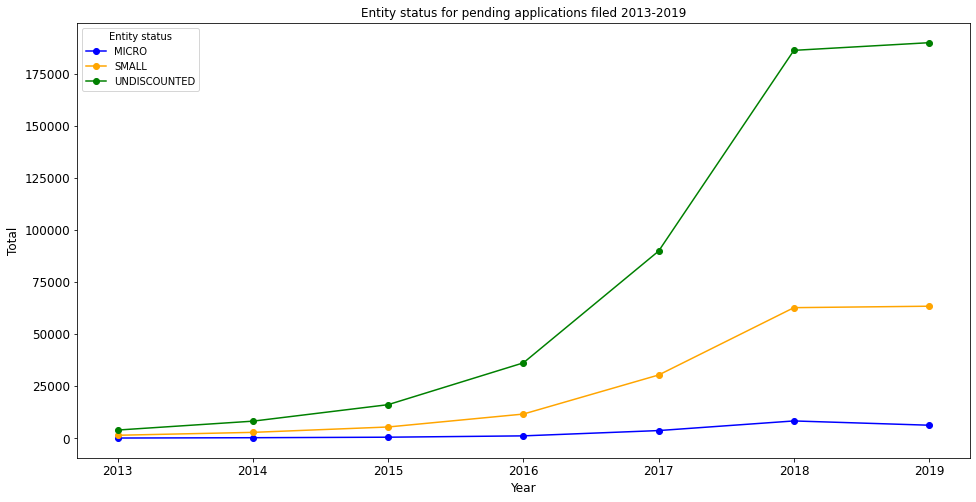

In [20]:
#'SMALL', 'UNDISCOUNTED', 'MICRO'
entity_status_pending = all_apps_2013_2019.groupby('year_filing')
#use .value_counts() to determine number of applications in each entity status group
entity_status_pending['small_entity_indicator'].value_counts().unstack().plot(figsize=(16,8), marker ='o')
plt.title('Entity status for pending applications filed 2013-2019', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.tick_params(labelsize = 12)
plt.legend(title='Entity status')
plt.show()

More applications left from undiscounted entities (corporations) than small or micro entities.

## 3.3 Patents issued (2000-2019)

In [21]:
#applications issued as patents from 2000-2019

#further processing of patented_applications
#subset to create all, utility, design, and plant pending application dataframes filed in 2000 and after
all_patents = patented_applications[patented_applications['year_patent'] >= '2000']

## 3.3.1 Technology Center (TC) Groups

In [22]:
#further processing of all_patents dataframe

#checking for unique 'technology center' values
#all_patents['technology_center'].unique()
all_patents_droplist = ['2700','2900', 'ST00', '000', '2500', '4100', 'OP00', '1900',
                        '2200', '3300', '1500', 'IP00', '1200', '3400', '3100','3500',
                        '2300', '1800', '1300', 'SI00', 'PC00', 'SP00', '3900','PT00',
                        'CS00', '8300', 'CQ00', 'PQ00', 'CC00', 'CO00', 'OQ00','DC00',
                        'BP00', 'EA00', 'MP00', 'PI00', 'OE00', 'DI00', 'PS00','OD00',
                        'PE00', 'DB00', 'WM00', 'IM00', 'LO00', 'OA00', 'IW00']

#remove rows with na values
all_patents_na = all_patents.dropna(subset=['technology_center'])

#remove rows with values not considered a current technology center group
#identify row names with the above all_patents_droplist 'values' in technology center
rows_all_patents = all_patents_na[all_patents_na['technology_center'].isin(all_patents_droplist)].index

#drop rows_TC to create the utility_TC dataframe
all_patents_TC = all_patents_na.drop(rows_all_patents)

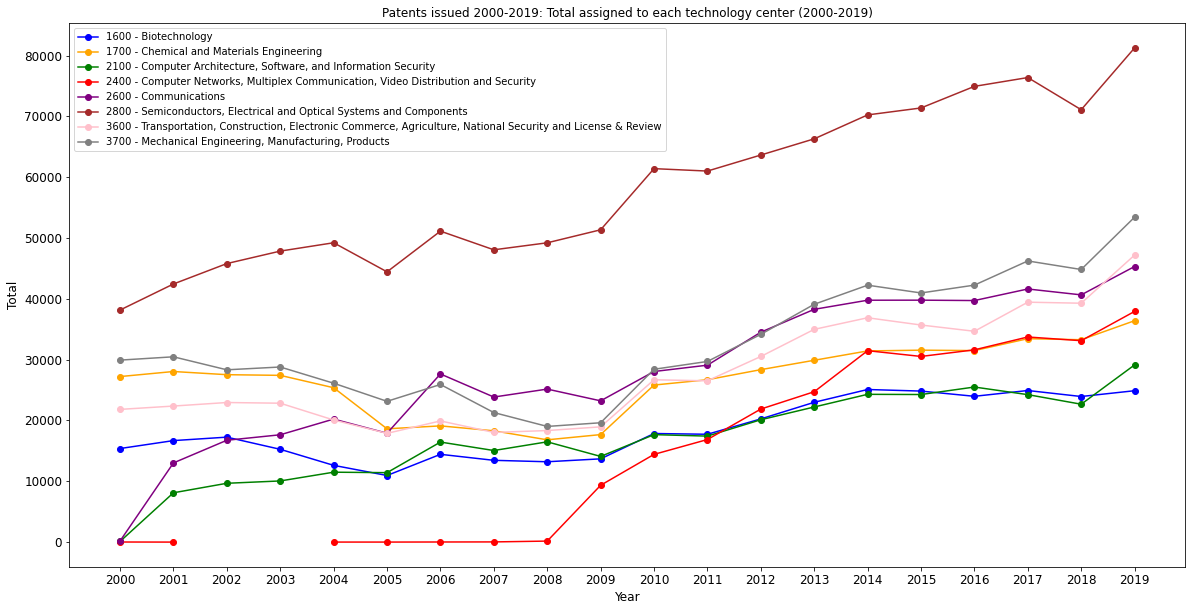

In [23]:
#plotting number of all (utility, design, and plant) patents in each technology center (2010-2019)
#art unit - 8 technology centers for examining utility applications

#groupby year_filing
art_unit_all_patents = all_patents_TC.groupby('year_patent')

#plot
art_unit_all_patents['technology_center'].value_counts().unstack().plot(figsize=(20,10), marker='o')
plt.title('Patents issued 2000-2019: Total assigned to each technology center (2000-2019)', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(fontsize = 12)
plt.tick_params(labelsize = 12)
#20 ticks, 1 for each year
plt.xticks(np.arange(20), labels=years)
plt.legend(labels = new_labels)
plt.show()

Most of the patents issued between 2000-2019 were from technology center (TC) group number 2800. This was the top TC group every year, from 2000-2019. The second top TC group changed over time, alternating between TC groups 3700, 2600, 3600, and 1700. The number of patents in TC group 2400 was significantly lower from 2000-2008 compared to the other groups, but has increased every year since then. There is a gap for the '2400' line from 2001-2004, meaning, based on the available data, there were no patents issued in 2002 and 2003 that were assigned to TC number 2400.

## 3.3.2 United States Patent Classification (USPC) class numbers (2000-2019)

In [24]:
#remove rows with na values in uspc_class column
all_patents_class_na = all_patents.dropna(subset=['uspc_class'])

#group by year
class_all_patents = all_patents_class_na.groupby('year_patent')

#use value_counts to determine how many patents are assigned to each uspto classification code
uspc_class_count_patents = class_all_patents['uspc_class'].value_counts()

In [25]:
#groupby year and get top 10 classification codes per year
plot_2 = uspc_class_count_patents.groupby(level=0).head(10).unstack()
#for easier visualization plot (1) 2000-2010 and (2) 2011-2019; how the top 10 has changed over time
plot_3 = plot_2.loc['2000':'2010']
plot_4 = plot_2.loc['2011':'2019']

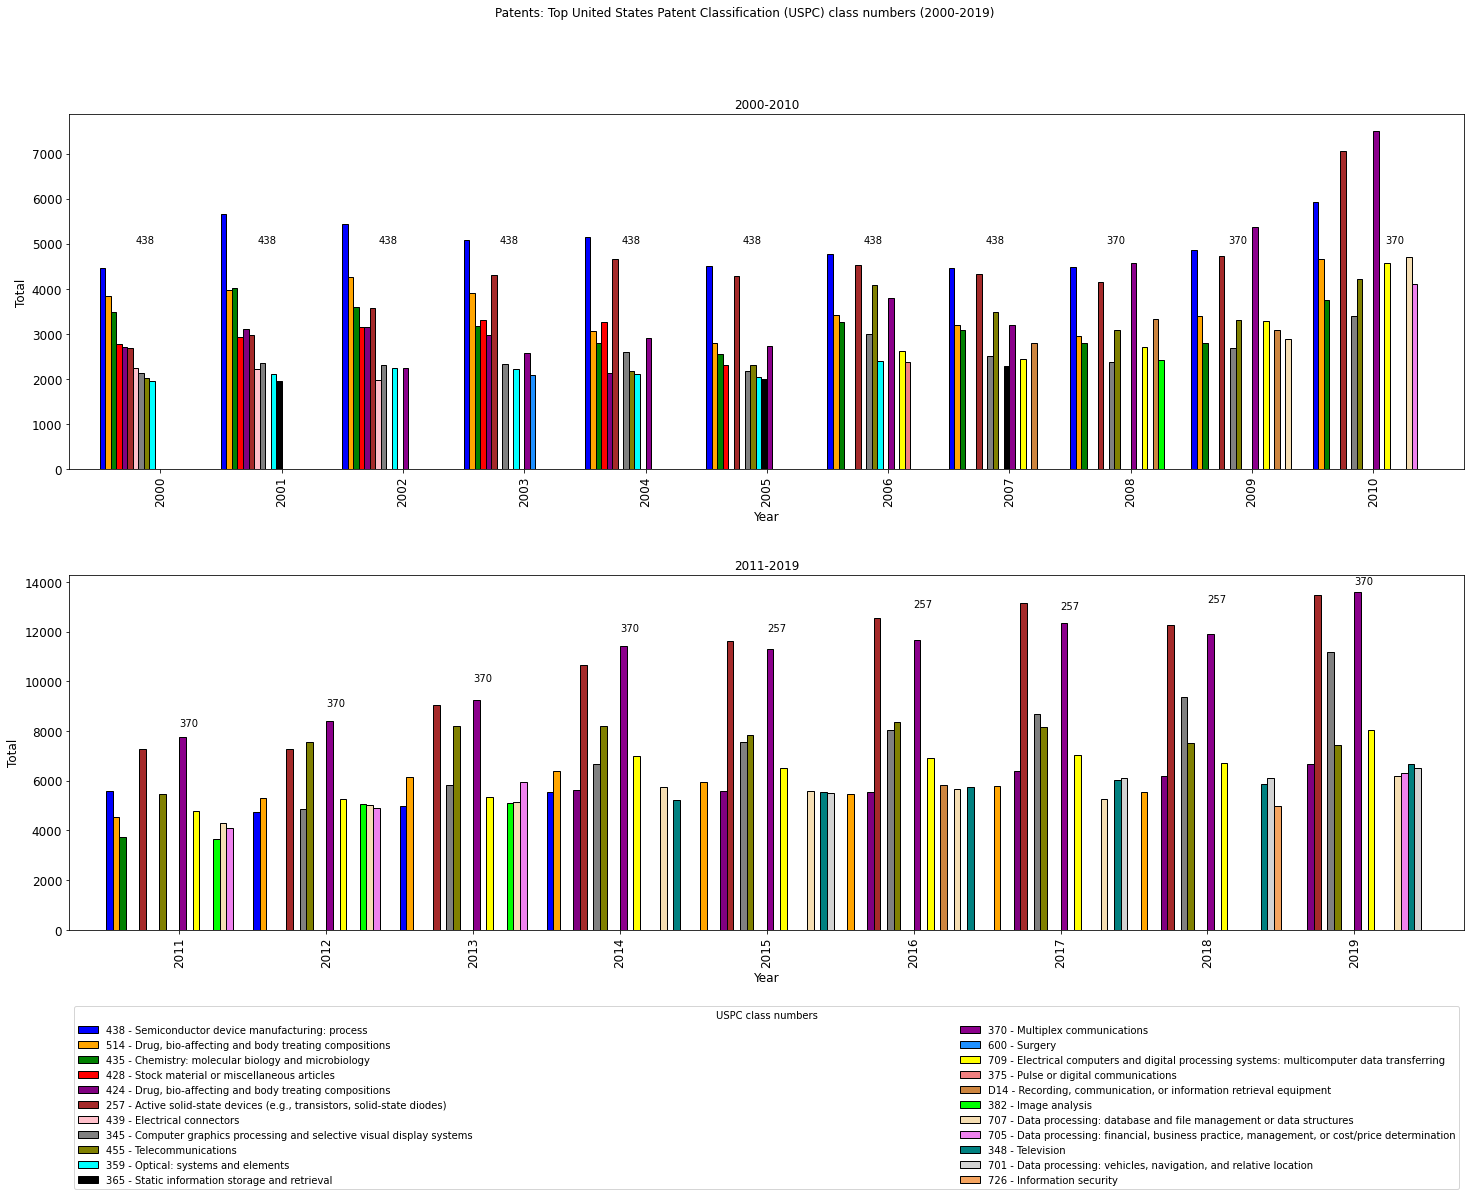

In [26]:
#make a subplot
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Patents: Top 10 United States Patent Classification (USPC) class numbers (2000-2019)', fontsize=12)
#fig.tight_layout()
fig.subplots_adjust(hspace=.3)

plot_3.plot.bar(figsize = (25,15), ax=ax1, width=1, edgecolor='black', legend=None)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total', fontsize=12)
ax1.set_title('2000-2010', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)
#adding text above each group to indicate top uspc class number for each year
ax1.text(-.2, 5000, '438')
ax1.text(0.8, 5000, '438')
ax1.text(1.8, 5000, '438')
ax1.text(2.8, 5000, '438')
ax1.text(3.8, 5000, '438')
ax1.text(4.8, 5000, '438')
ax1.text(5.8, 5000, '438')
ax1.text(6.8, 5000, '438')
ax1.text(7.8, 5000, '370')
ax1.text(8.8, 5000, '370')
ax1.text(10.1, 5000, '370')

plot_4.plot.bar(figsize=(25, 15), ax=ax2, width=1, edgecolor='black')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Total', fontsize=12)
ax2.set_title('2011-2019', fontsize=12)
ax2.tick_params(axis='both', labelsize=12)

#legend labels for ax1 and ax2 (both plots)
legend_labels_ax1_ax2 = ['438 - Semiconductor device manufacturing: process',
                     '514 - Drug, bio-affecting and body treating compositions', 
                     '435 - Chemistry: molecular biology and microbiology',
                     '428 - Stock material or miscellaneous articles',
                     '424 - Drug, bio-affecting and body treating compositions',
                     '257 - Active solid-state devices (e.g., transistors, solid-state diodes)', 
                     '439 - Electrical connectors', 
                     '345 - Computer graphics processing and selective visual display systems', 
                     '455 - Telecommunications', 
                     '359 - Optical: systems and elements',
                     '365 - Static information storage and retrieval', 
                     '370 - Multiplex communications', 
                     '600 - Surgery', 
                     '709 - Electrical computers and digital processing systems: multicomputer data transferring', 
                     '375 - Pulse or digital communications', 
                     'D14 - Recording, communication, or information retrieval equipment', 
                     '382 - Image analysis', 
                     '707 - Data processing: database and file management or data structures', 
                     '705 - Data processing: financial, business practice, management, or cost/price determination', 
                     '348 - Television',
                     '701 - Data processing: vehicles, navigation, and relative location',
                     '726 - Information security']
#replace ax2 legend labels with uspc class number and description (shared legend for both plots)
#horizontal legend, format
ax2.legend(labels=legend_labels_ax1_ax2, title='USPC class numbers', mode='expand', ncol=2, bbox_to_anchor=(0, -1.2,1,1), loc='upper center')
#adding text above each group to indicate top uspc class number for each year
ax2.text(0, 8200, '370')
ax2.text(1, 9000, '370')
ax2.text(2, 10000, '370')
ax2.text(3, 12000, '370')
ax2.text(4, 12000, '257')
ax2.text(5, 13000, '257')
ax2.text(6, 12900, '257')
ax2.text(7, 13200, '257')
ax2.text(8, 13900, '370')

plt.show()

From 2000-2007, 438 was the top USPC class number assigned to patents issued in that time period. 438 is for inventions related to semiconductor device manufacturing: process. From 2008-2014, top class number was 370. 370 is for inventions related to multiplex communications. From 2015-2018, top class number was 257. 257 is for inventions related to active solid-state devices (e.g., transistors, solid-state diodes). In 2019, top class number returned to 370.

# 3.3.3 Inventors (2000-2019)

In [27]:
#merging inventors dataframe and all_patents; analysis on inventors of patented applications
inventors_2000_2019 = pd.merge(all_patents, inventors, on='application_number')

#drop rows with na values in 'inventor_country_code' column
inventors_country_patent = inventors_2000_2019.dropna(subset=['inventor_country_code'])

#groupby year_patent and inventor_country_code
#removed na values, can use .size() to count number of inventors from each country
inventors_country_patent_count = inventors_country_patent.groupby(['year_patent','inventor_country_code']).size().reset_index(name='Total')

#rename column year_patent and inventor_country_code for plot labels
inventors_country_patent_count.rename(columns={"year_patent": "Year", 'inventor_country_code':'Country'}, inplace=True)

#view y range for plotting
#inventors_country_patent_count['count'].sort_values()

In [28]:
#plot - from plotly
fig = px.bar(inventors_country_patent_count, x="Country", y="Total", 
             title='Inventor count for each country for patents issued 2000-2019',
             animation_frame="Year", range_y=[0,600000])
fig.show()

Top inventor countries: U.S., Japan, Korea, China, and Germany.

# 3.3.3.1 U.S. Inventors

In [29]:
#subset - U.S. inventors, patents (2000-2019)
US_patent_inventors = inventors_2000_2019[inventors_2000_2019['inventor_country_code'] == 'US']

#remove rows with na values in inventor_region_code (state)
US_patent_inventors_final = US_patent_inventors.dropna(subset=['inventor_region_code'])

US_patent_inventors_count = US_patent_inventors_final.groupby(['year_patent','inventor_region_code']).size().reset_index(name='count')
#view y range for plotting - 95,000
#US_patent_inventors_count['count'].sort_values()

In [52]:
#from plotly, class lecture
def mapper_patents(year): #enter year as string
    plot_df = US_patent_inventors_count.loc[US_patent_inventors_count['year_patent'] == year] #subsetting dataframe by a given year
    
    fig =go.Figure(data=go.Choropleth(
        locations = plot_df['inventor_region_code'],
        z = plot_df['count'],
        text = plot_df['inventor_region_code'],
        locationmode='USA-states',
        autocolorscale=True,
        marker_line_color='rgb(255,255,255)',
        marker_line_width=2,
        colorbar_tickprefix = '',
        colorbar_title = 'Totals for ' + year
    ))
    
    fig.update_layout(
        title_text = 'Inventor count for each state for patents issued in ' + year + '<br>Hover for Value',
        geo = dict(
            showframe=False,
            showcoastlines=True,
            showlakes=True,
            lakecolor='rgb(95,145,237)',
            projection_type='albers usa')
    )
    fig.show()

In [53]:
#user can enter years 2000-2019
mapper_patents('2019')

Top inventor states: California, Texas, New York, Washington, and Massachusetts.

 # 3.3.4 Entity Status (2000-2019)

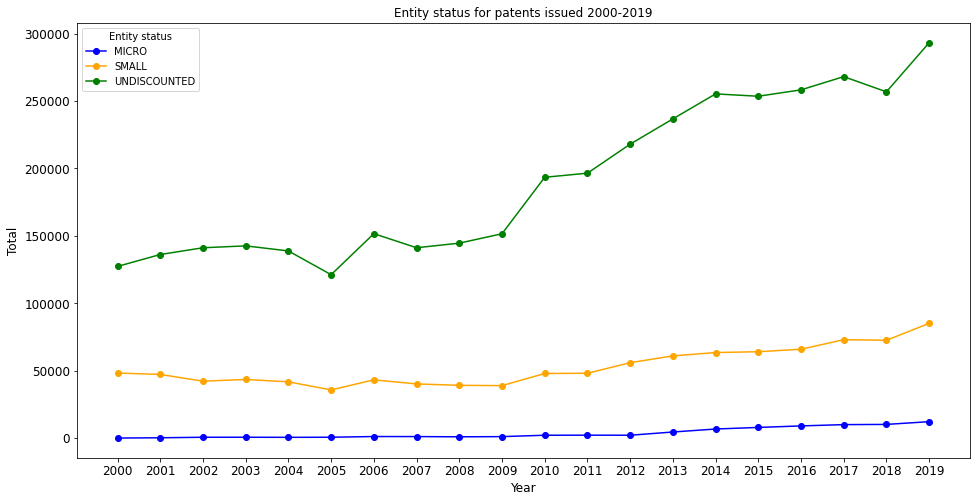

In [32]:
#'SMALL', 'UNDISCOUNTED', 'MICRO'
entity_status_patent = all_patents.groupby('year_patent')
entity_status_patent['small_entity_indicator'].value_counts().unstack().plot(figsize=(16,8), marker ='o')
plt.title('Entity status for patents issued 2000-2019', fontsize=12)
plt.ylabel('Total', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.tick_params(labelsize = 12)
#from earlier plot
plt.xticks(np.arange(20), labels=years)
plt.legend(title='Entity status')
plt.show()

Note that undiscounted entities (corporations) continue to have more patents issued under their name compared to small and micro entities. There doesn't appear to be a significant increase in the number of patent applications filed or issued in the name of small or micro entities over the past 20 years. 

# 4. Assignees

The assignee.csv file contains an ID that refers to an individual assignment (document) that was recorded with the USPTO along with the assignee name (the entity that as the property right to the patent) and address information. This section can provide a general idea of which areas are patent rich and which specific assignees have strong U.S. patent portfolios.

In [33]:
#analyzing assignment database - assignee count for each state

#remove na values
assignee_state_na= assignee.dropna(subset=['ee_state'])

#assignee['ee_state'].unique()
#remove rows with 'Armed Forces in Europe, the Middle East, Africa, and Canada' and 'Armed Forces in the Pacific' in ee_state column
state_drop = ['Armed Forces in Europe, the Middle East, Africa, and Canada','Armed Forces in the Pacific']

#identify row names with the above state_drop values
state_drop_rows = assignee_state_na[assignee_state_na['ee_state'].isin(state_drop)].index

#drop state_drop_rows
assignee_states = assignee_state_na.drop(state_drop_rows)

#use .value_counts() to determine assignee count for each state
assignee_states_count = assignee_states['ee_state'].value_counts().reset_index(name='count')

#rename index column
assignee_states_count.rename(columns={"index": "state"}, inplace=True)

#list(assignee_states_final["state"].unique())
#replace each state name with two letter state code
states = {'CALIFORNIA':'CA','NEW YORK':'NY','TEXAS':'TX','ILLINOIS':'IL','MASSACHUSETTS':'MA','MICHIGAN':'MI','NEW JERSEY':'NJ',
 'OHIO':'OH','WASHINGTON':'WA','PENNSYLVANIA':'PA','MINNESOTA':'MN','CONNECTICUT':'CT','MARYLAND':'MD','DELAWARE':'DE','FLORIDA':'FL',
 'VIRGINIA':'VA','COLORADO':'CO','NORTH CAROLINA':'NC','GEORGIA':'GA','WISCONSIN':'WI','INDIANA':'IN','MISSOURI':'MO','OREGON':'OR',
 'DISTRICT OF COLUMBIA':'DC','NEVADA':'NV','ARIZONA':'AZ','UTAH':'UT','TENNESSEE':'TN','IOWA':'IA','IDAHO':'ID','KANSAS':'KS','KENTUCKY':'KY',
 'NEW HAMPSHIRE':'NH','SOUTH CAROLINA':'SC','OKLAHOMA':'OK','NEW MEXICO':'NM','RHODE ISLAND':'RI','ALABAMA':'AL','LOUISIANA':'LA',
 'NEBRASKA':'NE','ARKANSAS':'AR','MAINE':'ME','VERMONT':'VT','MISSISSIPPI':'MS','MONTANA':'MT','SOUTH DAKOTA':'SD','WYOMING':'WY',
 'WEST VIRGINIA':'WV','NORTH DAKOTA':'ND','HAWAII':'HI','ALASKA':'AK'}

#replace name of states and create dataframe for plotting
assignee_states_final = assignee_states_count.replace(states)

In [34]:
#plotting assignee count
#from plotly and class lecture

fig =go.Figure(data=go.Choropleth(
        locations = assignee_states_final['state'],
        z = assignee_states_final['count'],
        text = assignee_states_final['state'],
        locationmode='USA-states',
        autocolorscale=True,
        marker_line_color='rgb(255,255,255)',
        marker_line_width=2,
        colorbar_tickprefix = '',
        colorbar_title = 'Total' 
    ))
    
fig.update_layout(
        title_text = 'Assignee count for each state as of 2019 <br>Hover for Value',
        geo = dict(
            showframe=False,
            showcoastlines=True,
            showlakes=True,
            lakecolor='rgb(95,145,237)',
            projection_type='albers usa')
    )
fig.show()

Top assignee states: California, Texas, New York, Illinois, and Massachusetts.

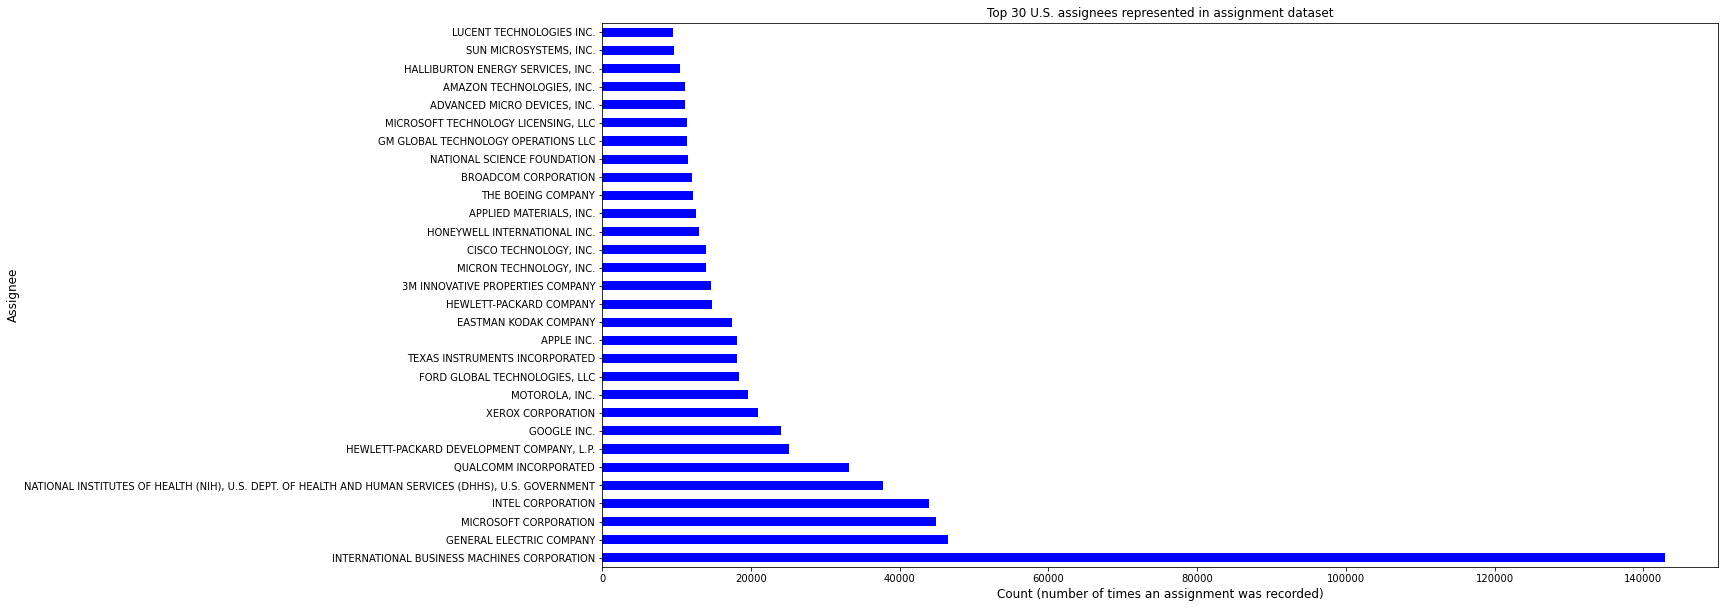

In [35]:
#use .value_counts() and .head() to identify top U.S. assignees represented in the assignment dataset
assignee_states['ee_name'].value_counts().head(30).plot(figsize=(20,10), kind='barh')
plt.title('Top 30 U.S. assignees represented in assignment dataset', fontsize=12)
plt.xlabel('Count (number of times an assignment was recorded)', fontsize=12)
plt.ylabel('Assignee', fontsize=12)
plt.show()

In [36]:
#assignee count for all countries, except the U.S.

#subset assignee dataframe based on two conditions
assignee_foreign = assignee[(assignee['ee_country']!='NOT PROVIDED') & (assignee['ee_country']!='UNITED STATES')]

#drop na values
assignee_foreign_final = assignee_foreign.dropna(subset=['ee_country'])

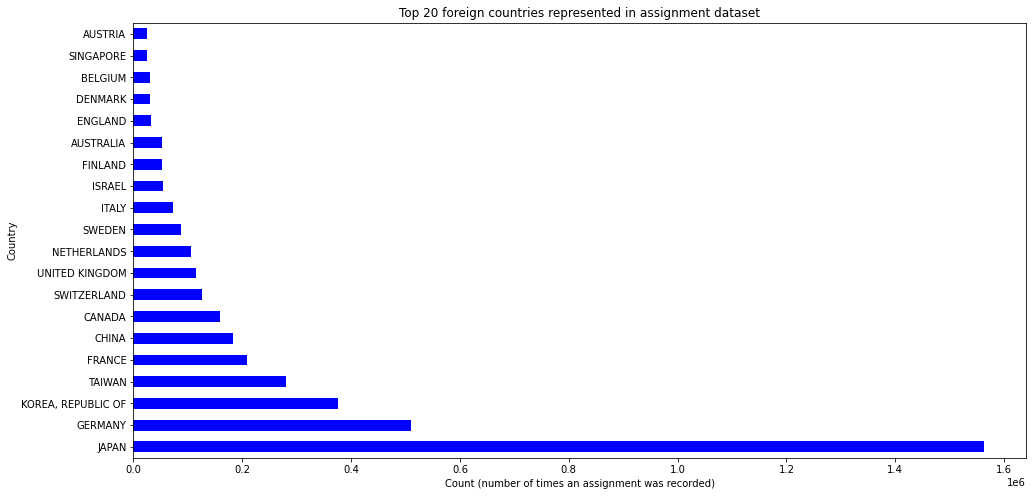

In [40]:
#use .value_counts() and .head() to identify top foreign countries represented in the assignment dataset
assignee_foreign_final['ee_country'].value_counts().head(20).plot(figsize=(16,8), kind='barh')
plt.title('Top 20 foreign countries represented in assignment dataset')
plt.xlabel('Count (number of times an assignment was recorded)') #number of times an assignment was recorded for an assignee in a given country
plt.ylabel('Country')
plt.show()

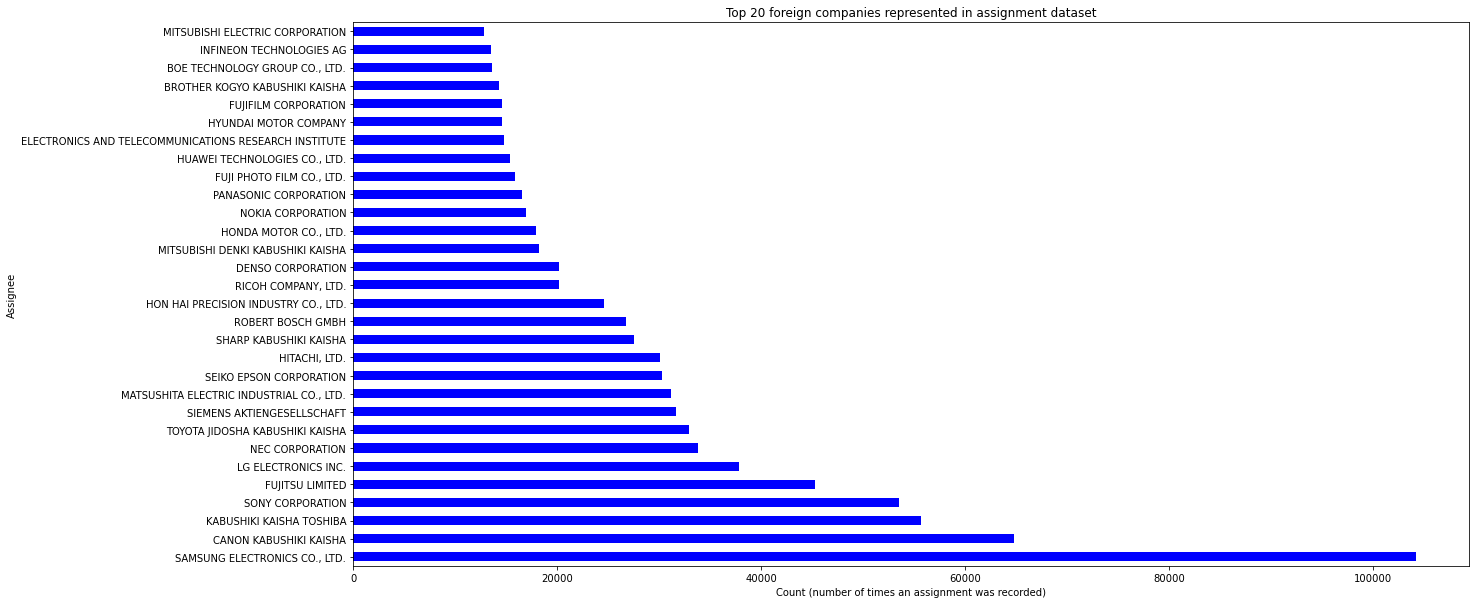

In [38]:
#use .value_counts() and .head() to identify top assignees represented in the assignment dataset
assignee_foreign_final['ee_name'].value_counts().head(30).plot(figsize=(20,10), kind='barh')
plt.title('Top 20 foreign companies represented in assignment dataset')
plt.xlabel('Count (number of times an assignment was recorded)') #number of times an assignment was recorded for a given assignee
plt.ylabel('Assignee')
plt.show()

# Conclusion

## Highlights

Overall increase in the number of applications filed with the USPTO, except for decreases in 2008-2009 and 2018-2019.

**Pending applications**

Top technology centers for applications filed 2000-2019:
1. 2800 - Semiconductors, Electrical and Optical Systems and Components
2. 3700 - Mechanical Engineering, Manufacturing, Products
3. 3600 - Transportation, Construction, Electronic Commerce, Agriculture, National Security and License & Review
4. 1700 - Chemical and Materials Engineering

Top USPC class numbers for applications filed 2013-2019:
1. 2013-2017: 705 - data processing: financial, business practice, management, or cost/price determination
2. 2014-2018: 424 - drug, bio-affecting and body treating compositions
3. 2019: 370 - multiplex communications

**Patents**

Top technology centers for patents issued 2000-2019:
1.  2800 - Semiconductors, Electrical and Optical Systems and Components (top TC group every year)
2. The number of patents in TC group 2400 was significantly lower from 2000-2008 compared to the other groups, but has increased every year since then. 2400 - Computer Networks, Multiplex, Cable and Cryptography/Security

Top USPC class numbers for patents issued 2000-2019:
1. 2000-2007: 438 - semiconductor device manufacturing: process
2. 2008-2014: 370 - multiplex communications
3. 2015-2018: 257 - active solid-state devices (e.g., transistors, solid-state diodes)
4. 2019: 370 - multiplex communications

**Inventors**

Top inventor countries: U.S., Japan, Korea, China, and Germany

Top inventor states: California, Texas, New York, and Washington

**Entity status**

Note that undiscounted entities (corporations) continue to file significantly more applications and have more patents issued under their name compared to small and micro entities. A small increase in the number of patent applications and issued patents for small entities.

**Assignees**

Top assignee states: California, Texas, New York, Illinois, and Massachusetts

Top foreign countries: Japan, Germany, Republic of Korea, Taiwan, and France 

Top foreign company: Samsung Electronics Co., Ltd.

Top U.S. company: International Business Machines Corporation (IBM)

**Published**

Github: https://ibarahona.github.io/DATS6103-Project-3/

Zenodo: https://zenodo.org/record/4321830#.X9fummRKhQM